In [1]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import scipy as sp
import io_utils as io
import dask.array as da



# Preliminaries

la simulation chargée est: dahu_519
depuis: dahu
shape of psi : (132, 2049, 2049)
{'NX': 2048.0, 'NY': 2048.0, 'nl': 1.0, 'Lx': 502.65482457, 'f0': 2.0, 'beta': 1.0, 'k_f': 1.0, 'sigma_f': 1.0, 'bc_fac': 0.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 0.00077160493827, 'n_hyper': 4.0, 'hEkb': 0.00390625, 'tend': 1576800000000.0, 'dt_out': 0.05}


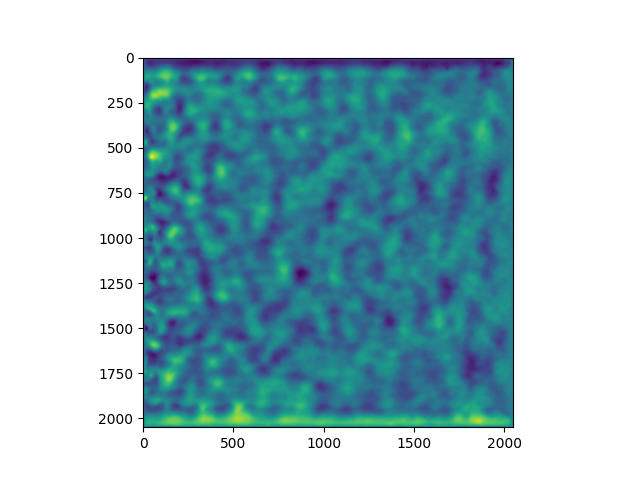

In [2]:


# Number of simulation
n = 519

# Choose between 'local' or 'dahu'
where = 'dahu'

# Reading the netcdf file
if where == 'local':
    if n < 10:
        simu_name = 'outdir_000' + str(n)
    elif n < 100 and n >= 10:
        simu_name = 'outdir_00' + str(n)
    Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
elif where == 'dahu':
    simu_name = 'dahu_' + str(n)
    Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'
else:
    print('Error: where not recognized')
    sys.exit()

print('la simulation chargée est: ' + simu_name)
print("depuis: " + where)

filenames = ['/vars.nc']

# Open the dataset using xarray
dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


# Load variables in chunks
t = dataset['time'].data
x = dataset['x'].data
y = dataset['y'].data
psi = dataset['psi'].isel( level=0).data
q = dataset['q'].isel(level=0).data
print("shape of psi :",np.shape(psi))
# Lecture des paramètres :
param = io.read_params(Path)
print(param)
f0 = param['f0']
beta = param['beta']
hEkb = param['hEkb']
dh = param['dh'][0]
Lx = param['Lx']
nx = int(param['NX'])
ny = int(param['NY'])
k_f = param['k_f']
sigma_f = param['sigma_f']
bc_fac = param['bc_fac']
nu_hyper = param['nu_hyper']
n_hyper = param['n_hyper']
dt_out = param['dt_out']

plt.figure()
plt.imshow(psi[-2, :, :])



In [3]:
def project_basin(q, m, n, L, norm = 0):
    ''' gives back complex amplitude that describes the projection of the field q onto the basin mode n,m. Projection on q gives the energy (in which case norm = 1 gives the proper normalisation), but works on any field.'''
    
    N  = np.shape(q)[-1]
    
    X = np.linspace(0, L, N)
    Y = np.linspace(0, L, N)
    x, y = np.meshgrid(X, Y)
    
    mode = np.exp(-1j*np.pi*np.sqrt(m**2 + n**2)*x/L)*np.sin(m*np.pi*x/L)*np.sin(n*np.pi*y/L)
    
    delta = L/(N-1)
    
    if norm:
        coeff_mn = (-np.pi**2*(n**2 +m**2)/4)*(mode*q).sum(axis = (-2,-1))*delta**2
    else:
        coeff_mn = (mode*q).sum(axis = (-2,-1))*delta**2
        
    return coeff_mn

In [4]:
#Computing k_rhines to have an idea of the modes to choose

epsilon=sigma_f**2
r=hEkb
k_rhines=beta**0.5/(epsilon/r)**(1/4)

print('k_rhines =',k_rhines)    

n=Lx*(k_rhines)/(2*np.pi)
print("Just look arround n",n)

k_rhines = 0.25
Just look arround n 19.999999999826247


(132,)


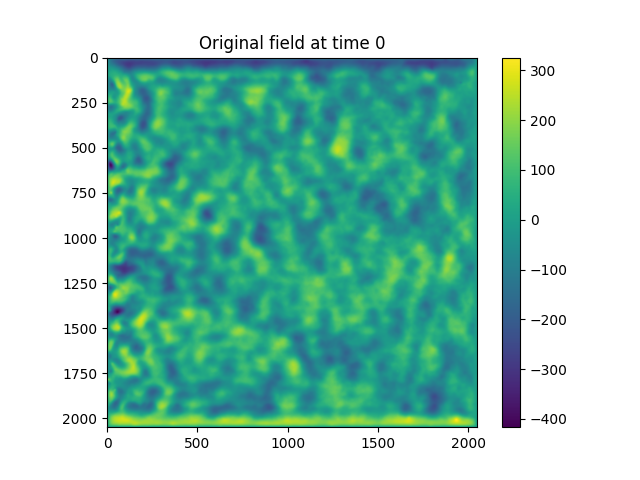

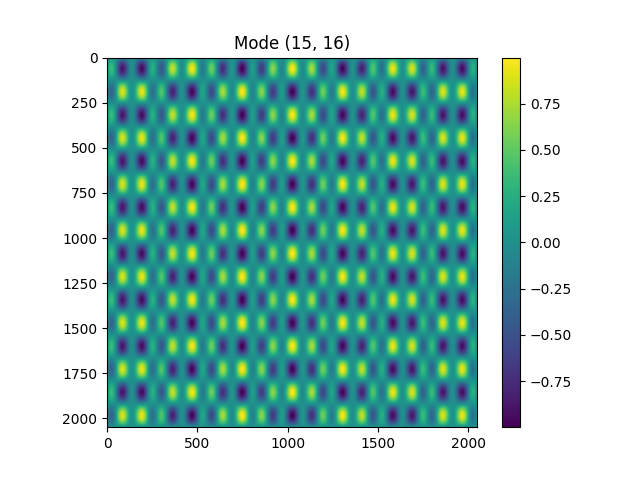

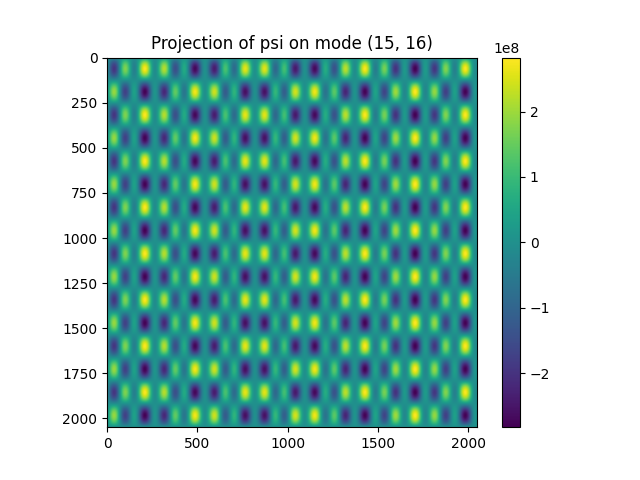

In [11]:
m_sel=15
n_sel=16

time_sel=np.arange(0,len(t),1,dtype=int)
time_plotted=0

psi_mn = project_basin(psi[time_sel,:,:], m_sel, n_sel, Lx, norm = 1)
print(np.shape(psi_mn))
# Visualize the original field
plt.figure()
plt.imshow(psi[time_plotted, :, :])
plt.colorbar()
plt.title(f'Original field at time {time_plotted}')
plt.show()

# Construct and visualize the mode
N = np.shape(psi[time_plotted, :, :])[-1]
x = np.linspace(0, Lx, N)
y = np.linspace(0, Lx, N)
X, Y = np.meshgrid(x, y)

mode = np.exp(-1j*np.pi*np.sqrt(m_sel**2 + n_sel**2)*X/Lx) * np.sin(m_sel*np.pi*X/Lx) * np.sin(n_sel*np.pi*Y/Lx)

plt.figure()
plt.imshow(np.real(mode))
plt.colorbar()
plt.title(f'Mode ({m_sel}, {n_sel})')
plt.show()

# Reconstruct and visualize the projected field
reconstructed_field = np.real(psi_mn[time_plotted] * mode)

plt.figure()
plt.imshow(reconstructed_field)
plt.colorbar()
plt.title(f'Projection of psi on mode ({m_sel}, {n_sel})')
plt.show()


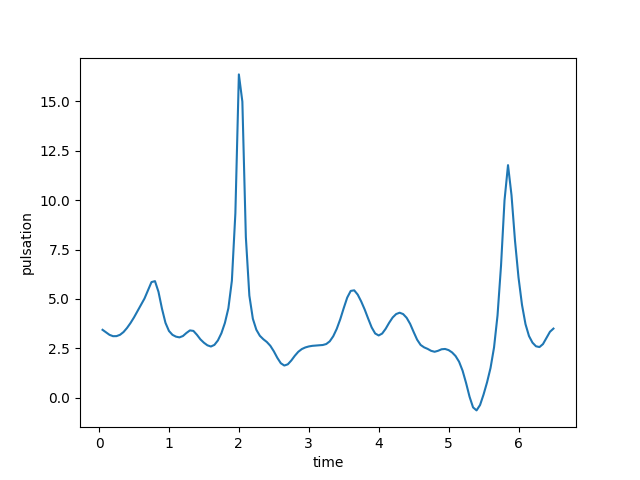

In [12]:
dt=t[1]-t[0]    

# now we calculate the wave pulsation, using the same formula as for the spectral code
dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2])/(2*dt)

pulsation_observed = np.imag(np.conj(psi_mn[1:-1])*dpsi_mn_dt)/np.abs(psi_mn[1:-1])**2

plt.figure()
plt.plot(t[1:-1],pulsation_observed)
plt.xlabel('time')
plt.ylabel('pulsation')
plt.show()

In [13]:

def pulsation(psi_mn,t):
    """Calculates the pulsation of the wave from the projection of the field psi on the mode (m,n)"""

    dt = t[1] - t[0]
    dpsi_mn_dt = (psi_mn[2:] - psi_mn[:-2]) / (2 * dt)
    
    pulsation_observed_brut = np.imag(np.conj(psi_mn[1:-1]) * dpsi_mn_dt) / np.abs(psi_mn[1:-1])**2
    pulsation_var = pulsation_observed_brut**2

    return pulsation_observed_brut,pulsation_var

# Finding the waves

In [14]:
#Code with parallelization
from joblib import Parallel, delayed

# Parameters
m_list = np.arange(5, 30, 1) #Modes already checked : 15-30
n_list = np.arange(1, 30, 1) #Modes already checked : 16-22
epsilon1 = 0.3
epsilon2 = 0.3
time_sel=np.arange(0,len(t),1,dtype=int)

pi = np.pi
list_modes = []
list_pulsation = []
def find_mode(m_sel, n_sel):
    """
    Process a single (m, n) mode and return the data for plotting if conditions are met.
    """
    #pulsation_mode_theo = beta * Lx / (np.sqrt(m_sel**2 + n_sel**2) * 2 * pi)
    
    #finding the projection of the field on the mode
    psi_mn = project_basin(psi[time_sel, :, :], m_sel, n_sel, Lx, norm=1)
    
    pulsation_observed_brut,pulsation_var = pulsation(psi_mn,t)
    std = np.sqrt(np.mean(pulsation_var, axis=0) - np.mean(pulsation_observed_brut, axis=0)**2)

    real = np.real(psi_mn)
    imag = np.imag(psi_mn)
    
    #Conditions to discriminates the modes whith wavelike behaviour
    condition1 = np.std(np.abs(np.sqrt(real**2 + imag**2)), axis=0) / np.mean(np.abs(np.sqrt(real**2 + imag**2)), axis=0) < epsilon1
    condition2 = std / np.abs(np.mean(pulsation_observed_brut, axis=0)) < epsilon2
    
    if condition1 and condition2:
        
        return (real, imag, m_sel, n_sel,np.mean(pulsation_observed_brut, axis=0))
    
    return None

results = Parallel(n_jobs=-1)(delayed(find_mode)(m, n) for m in m_list for n in n_list)




5 7
5 9
5 10
5 12
5 13
5 14
5 15
5 16
5 18
5 21
6 9
6 11
6 12
6 13
6 16
6 18
7 9
7 12
7 13
7 14
7 15
7 17
7 18
8 8
8 10
8 13
8 15
8 18
9 10
9 11
9 12
9 13
9 14
9 17
9 18
9 25
9 27
10 10
10 13
10 15
10 17
10 18
10 25
11 7
11 8
11 10
11 13
11 14
11 17
11 18
11 20
12 13
12 24
13 14
13 18
14 11
14 13
14 14
14 15
15 17
16 17
16 19
16 23
16 28
17 23
17 25
17 28
18 23
21 14
28 20
29 20


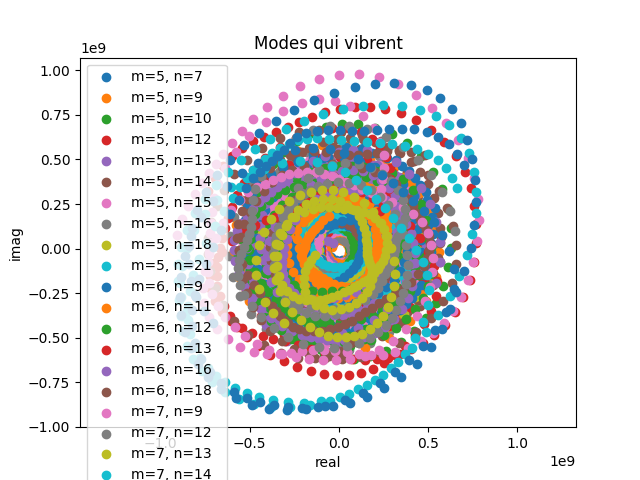

In [23]:
# Plotting and saving the pulsation in an array
filtered_results = [result for result in results if result is not None]


pulsation_array = np.zeros(len(filtered_results))
mn_wave_array = np.zeros((len(filtered_results),2))



plt.figure()
for index,result in enumerate(filtered_results):
    
    real, imag, m_sel, n_sel,pulsation = result
    print(m_sel, n_sel)
    pulsation_array[index]=pulsation
    mn_wave_array[index,0]=m_sel
    mn_wave_array[index,1]=n_sel
    plt.scatter(real, imag, label=f'm={m_sel}, n={n_sel}')
    plt.legend()

plt.xlabel('real')
plt.ylabel('imag')
plt.title('Modes qui vibrent')
plt.axis('equal')   
plt.savefig("../figures/Wave_sign_closed_case/mode_vibration_{}_{}.png".format(epsilon1, epsilon2))
plt.show()

In [ ]:
#saving the modes in a file
np.save("./Saving_modes/modes_{}_{}.npy".format(epsilon1, epsilon2),mn_wave_array)
np.save("./Saving_modes/pulsation_{}_{}.npy".format(epsilon1, epsilon2),pulsation_array)

The modes behaving like waves seems to be between 15 and 25

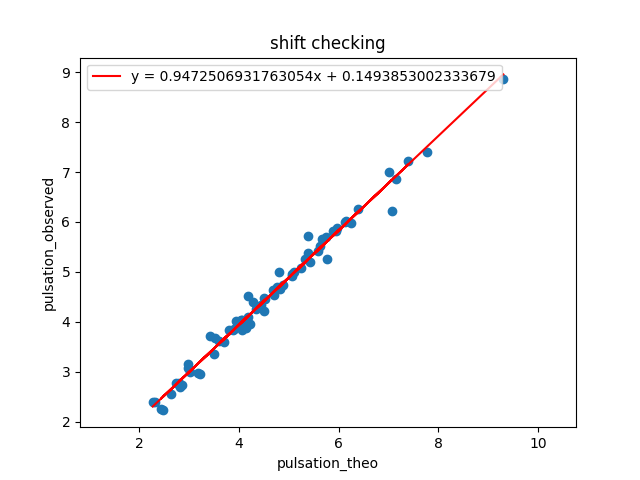

In [22]:
#Checking if the modes are doppler shifted

pulsation_theo=beta*Lx/(np.sqrt(mn_wave_array[:,0]**2+mn_wave_array[:,1]**2)*2*np.pi)
#interpoling the line
pol = np.polyfit(pulsation_theo,pulsation_array,1)
plt.figure()
plt.scatter(pulsation_theo,pulsation_array)
plt.plot(pulsation_theo,np.polyval(pol,pulsation_theo),label='y = {}x + {}'.format(pol[0],pol[1]),color='red')
plt.xlabel('pulsation_theo')
plt.ylabel('pulsation_observed')
plt.title('shift checking')
plt.axis('equal')
plt.legend()
plt.savefig("../figures/Wave_sign_closed_case/doppler_shift_{}_{}.png".format(epsilon1, epsilon2))
plt.show()

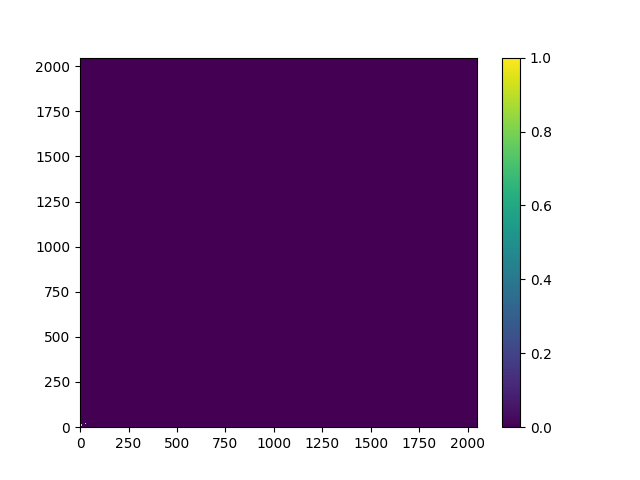

In [26]:
#Plotting the binary maps of the wavelike modes

binary_map = np.zeros((nx,ny))
Mx=np.arange(0,nx,1)
Ny=np.arange(0,ny,1)
X,Y=np.meshgrid(Mx,Ny)
plt.figure()

for i in range(0,len(mn_wave_array)):
    
    binary_map[int(mn_wave_array[i,1]), int(mn_wave_array[i,0])] = 1

plt.pcolormesh(X,Y,binary_map) 
plt.colorbar()

plt.show()